In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as const
from cupy import isnan
from scipy.signal import convolve
from scipy.fft import rfft, irfft, rfftfreq
from scipy import signal
from scipy.interpolate import interp1d
from scipy.io import savemat

# 常量定义
G = const.G # 万有引力常数, m^3 kg^-1 s^-2
c = const.c  # 光速, m/s
msun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

m1：34.26
m2：32.49
啁啾质量：29.04
采样率：16384
总样本数：524288
源距离：410.0000
天体透镜质量：1.0000e+07
y:0.6000


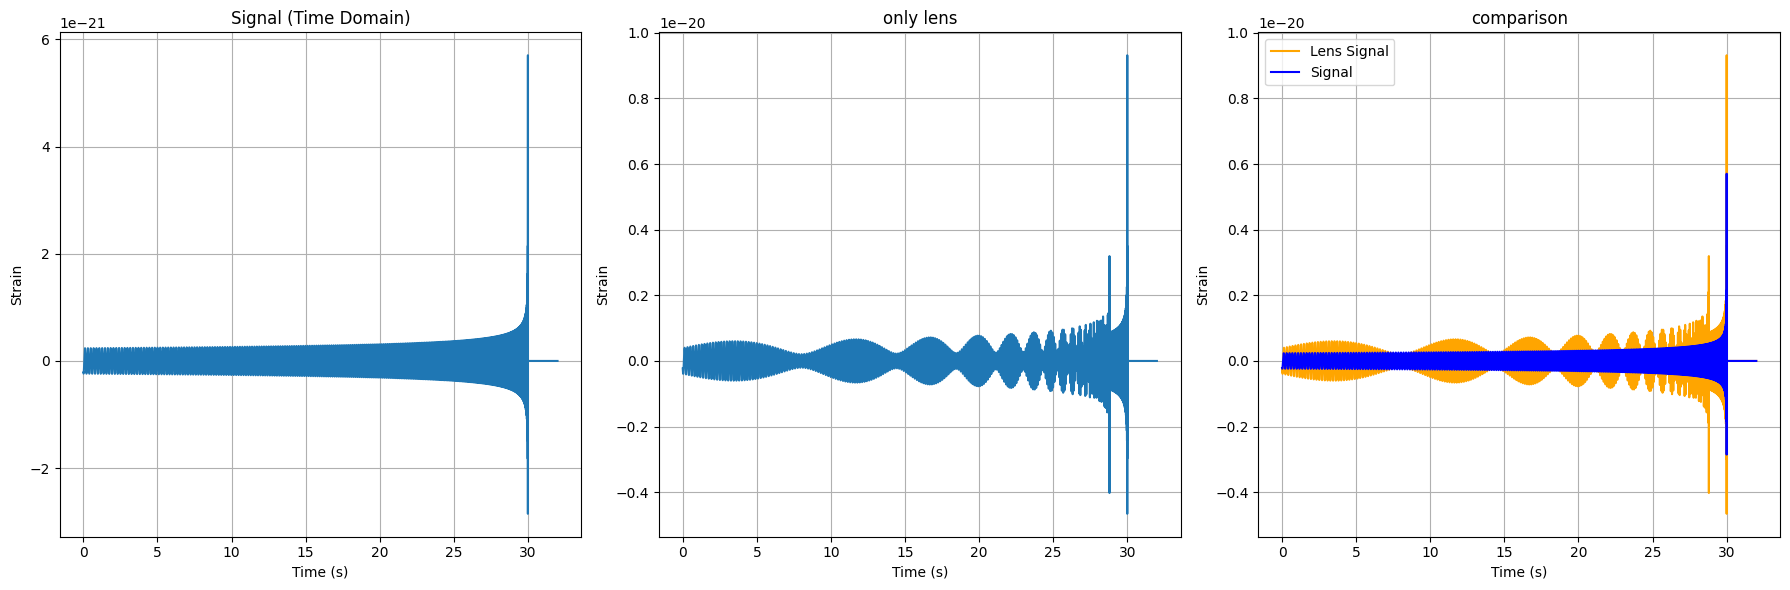

In [7]:
# 初始参数 - GW150914
m1 = 34.26          # 第一个黑洞质量（太阳质量）
m2 = 32.49         # 第二个黑洞质量（太阳质量）
# M_chirp = (m1 * m2 / (m1 + m2) ** 2) ** (3/5) * (m1 + m2)  # 啁啾质量
M_chirp = (m1 * m2) ** (3/5) / (m1 + m2) ** (1/5)
M_chirp = M_chirp * msun  # 转换为kg

# 透镜参数
mlz = 1e7 * msun  # 透镜质量
y = 0.6       # 影响参数

# 采样参数 - 与LIGO一致
fs = 16384       # 采样率调整为LIGO的标准采样率
dt = 1/fs
t = np.arange(0, 32, dt)  # 时间范围调整，使其更加聚焦于合并前的最后阶段
t_len = t[-1] - t[0]
N = len(t)

# 引力波参数 - 调整以匹配GW150914
tc = 30      # 合并时间，选择使信号在最后时刻达到峰值
phi_c = 0     

# SIS透镜参数
r = 410 * 1e6 * pc   # 源距离 (410 Mpc)

# 函数：引力波波形生成（啁啾信号）
def generate_gw_signal(t):
    # 确保在合并前截止
    valid_idx = t < tc
    t_valid = t[valid_idx]
    # 计算Θ(t)，控制信号的频率演化
    Theta = c**3 * (tc - t_valid) / (5 * G * M_chirp)
    # 计算振幅部分
    A = (G * M_chirp / (c**2 * r)) * Theta**(-1/4)
    
    # 原始相位计算
    phase = 2 * phi_c - 2 * Theta**(5/8)
    
    # 计算波形
    h = np.zeros_like(t)
    h[valid_idx] = A * np.cos(phase)
    return h

## 函数：透镜放大因子（时域方法2）
def lens_time(h_original, t, y):
    # 计算放大因子
    mu_plus = np.sqrt(1 + 1/y)  # 主像
    mu_minus = np.sqrt(-1 + 1/y) if y < 1 else 0  # 次像
    
    # 计算物理时间延迟
    td = 2 * y  # 秒
    # 创建插值函数
    interp_func = interp1d(t, h_original, kind='cubic', bounds_error=False, fill_value=0)
    # 创建延迟时间点
    t_delayed = t +td 
    
    # 计算延迟信号
    h_delayed = interp_func(t_delayed)
    
    # 透镜化效应：原始信号和延迟信号的组合
    h_lensed = mu_plus * h_original
    
    # 只有在y<1时才有次像
    if y < 1:
        h_lensed = h_lensed - mu_minus * h_delayed  # 次像有π相位差(负号)
    return h_lensed
# 计算引力波信号
h = generate_gw_signal(t)
h_lens = lens_time(h, t, y)
# 输出计算的时间延迟

print(f'm1：{m1}')
print(f'm2：{m2}')
print(f'啁啾质量：{M_chirp / msun:.2f}')
print(f'采样率：{fs}')
print(f'总样本数：{N}')
print(f'源距离：{r / 1e6 / pc :.4f}')
print(f'天体透镜质量：{mlz / msun:.4e}')
print(f"y:{y:.4f}")

# 绘制原始信号的时域和频域表示
plt.figure(figsize=(18, 6)) 
# 时域原始信号
plt.subplot(131)
plt.plot(t, h)
plt.title('Signal (Time Domain)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.subplot(132)
plt.plot(t, h_lens, label='Lens Signal(T)')
plt.title('only lens')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.tight_layout()
plt.subplot(133)
plt.plot(t, h_lens,'orange', label='Lens Signal')
plt.plot(t, h,'b',label='Signal')
plt.title('comparison')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# h_freqs = np.fft.fftfreq(len(h),t[1] - t[0])
# f_h = np.fft.fft(h)
# fig = plt.figure(figsize=(18, 6))
# plt.plot(h_freqs, np.real(f_h))
# plt.yscale('log')
# plt.xscale('log')
# plt.show()


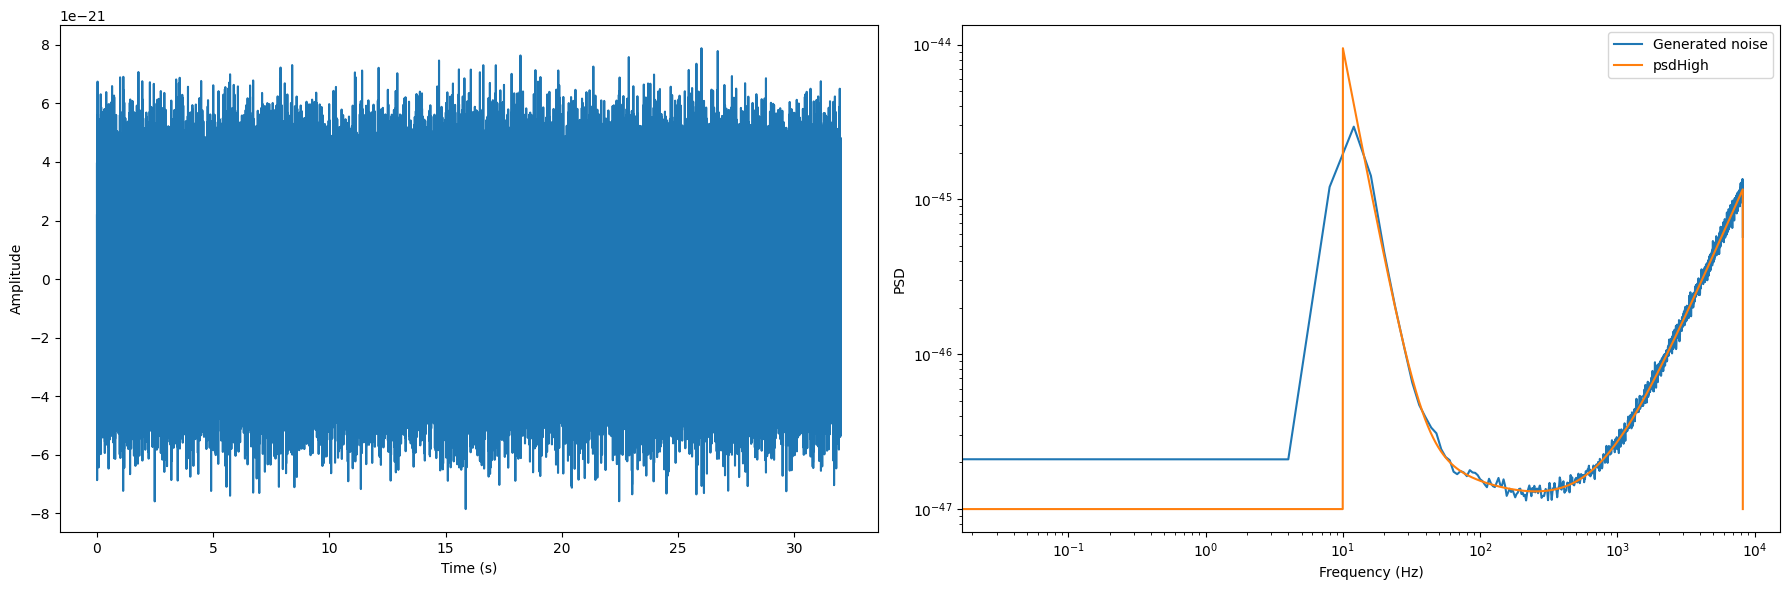

In [8]:
import pycbc.noise
import pycbc.psd
from scipy.signal import welch

fs = 16384  # This seems to be missing in your code
N = 32 * fs  # Total number of samples for 20 seconds
flow = 10
delta_f = 1 / 32
delta_t = 1 / fs
t = np.arange(0, N) * delta_t

# Generate PSD and noise
f_len = int(N // 2) + 1
psdHigh = pycbc.psd.aLIGOZeroDetHighPower(f_len, delta_f, flow)
psdHigh = np.maximum(psdHigh, 1e-47)
output_noise = pycbc.noise.noise_from_psd(N, delta_t, psdHigh)

# Plot time domain
fig = plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(t, output_noise)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Calculate PSD with Welch method - use proper parameters
f, pxx = welch(output_noise, fs=fs, nperseg=4096, noverlap=2048, scaling='density')

# Convert PyCBC PSD to numpy array with correct frequency axis
psd_freq = np.arange(len(psdHigh)) * delta_f

# Plot frequency domain
plt.subplot(122)
plt.plot(f, pxx, label='Generated noise')
plt.plot(psd_freq, psdHigh, label='psdHigh')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.tight_layout()
plt.show()

savemat('noise.mat',{'noise':output_noise,'psd':psdHigh})

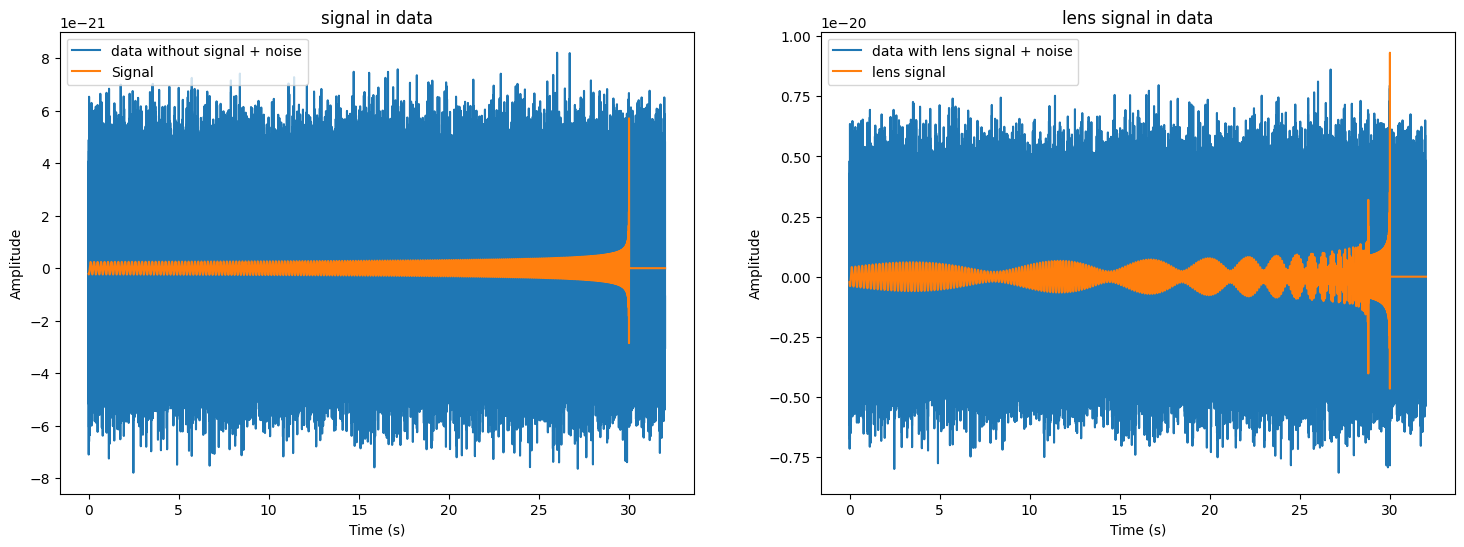

In [9]:
data = h + output_noise
data_lens = h_lens + output_noise
# data = h_windowed + output_noise
# data_lens = h_lens_windowed + output_noise

fig = plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(t, data, label='data without signal + noise')
# plt.plot(t, h_windowed, label='Signal')
plt.plot(t, h, label='Signal')
plt.title('signal in data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.subplot(122)
plt.plot(t,data_lens, label='data with lens signal + noise')
# plt.plot(t, h_lens_windowed, label='lens signal')
plt.plot(t, h_lens, label='lens signal')
plt.title('lens signal in data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

savemat('data_without_lens.mat',{'data':data,'samples':fs,'t0':t[0],'t1':t[-1]})
savemat('data.mat',{'data':data_lens,'samples':fs,'t0':t[0],'t1':t[-1]})


In [10]:
import pycbc.filter
from pycbc.types import TimeSeries, FrequencySeries
import pandas as pd

# 确保所有变量都是numpy数组
h_np = np.array(h, dtype=float)
h_lens_np = np.array(h_lens, dtype=float)
if hasattr(psdHigh, 'numpy'):
    psdHigh_np = psdHigh.numpy()
else:
    psdHigh_np = np.array(psdHigh, dtype=float)

# PyCBC方法计算信噪比
def calculate_snr_pycbc(signal, psd, fs):
    """
    使用PyCBC的matched_filter计算信噪比
    """
    # 创建PyCBC的TimeSeries对象
    delta_t = 1.0/fs
    ts_signal = TimeSeries(signal, delta_t=delta_t)
    
    # 创建PyCBC的FrequencySeries对象
    delta_f = 1.0/(len(signal)*delta_t)
    # 确保PSD长度与频率点数匹配
    
    psd_series = FrequencySeries(psd, delta_f=delta_f)
    
    # 使用matched_filter计算SNR
        # 模板与信号匹配（两者相同）
    snr = pycbc.filter.matched_filter(ts_signal, ts_signal, psd=psd_series, low_frequency_cutoff=10.0)
    # 获取最大SNR值
    max_snr = abs(snr).max()
    return float(max_snr)

# 内积方法计算信噪比
def calculate_snr_inner(signal, psd, fs):
    """
    使用内积方法计算SNR，基于您提供的innerprodpsd函数
    """
    # 修改内积函数以返回正确的SNR
    def inner_product(x, y, fs, psd):
        """计算两个信号在给定PSD下的内积"""
        nsamples = len(x)
        kNyq = nsamples // 2 + 1
            
        # 计算傅里叶变换
        fft_x = np.fft.rfft(x)
        fft_y = np.fft.rfft(y)
        
        # 计算内积
        df = fs / nsamples  # 频率分辨率
        prod = 4 * np.sum((fft_x * np.conj(fft_y) / psd[:len(fft_x)]) * df)
        
        return np.real(prod)
    
    # 计算信号的内积以获取SNR
    signal_energy = inner_product(signal, signal, fs, psd)
    
    # SNR是信号能量的平方根
    return np.sqrt(signal_energy)

# 计算SNR
print("\n===== 使用PyCBC方法计算信噪比 =====")
try:
    snr_pycbc_h = calculate_snr_pycbc(h_np, psdHigh_np, fs)
    snr_pycbc_h_lens = calculate_snr_pycbc(h_lens_np, psdHigh_np, fs)
    if snr_pycbc_h is not None and snr_pycbc_h_lens is not None:
        print(f"未透镜化信号信噪比 (PyCBC): {snr_pycbc_h:.4f}")
        print(f"透镜化信号信噪比 (PyCBC): {snr_pycbc_h_lens:.4f}")
        print(f"透镜效应导致的信噪比增强: {snr_pycbc_h_lens/snr_pycbc_h:.4f}倍")
    else:
        print("PyCBC方法计算失败")
except Exception as e:
    print(f"PyCBC方法出错: {e}")
    snr_pycbc_h = None
    snr_pycbc_h_lens = None

print("\n===== 使用内积方法计算信噪比 =====")
snr_inner_h = calculate_snr_inner(h_np, psdHigh_np, fs)
snr_inner_h_lens = calculate_snr_inner(h_lens_np, psdHigh_np, fs)
print(f"未透镜化信号信噪比 (内积): {snr_inner_h:.4f}")
print(f"透镜化信号信噪比 (内积): {snr_inner_h_lens:.4f}")
print(f"透镜效应导致的信噪比增强: {snr_inner_h_lens/snr_inner_h:.4f}倍")

# 计算信噪比的另一种简单方法（作为对比）
def direct_snr(signal, noise):
    """直接计算时域的信噪比"""
    signal_rms = np.sqrt(np.mean(signal**2))
    noise_rms = np.sqrt(np.mean(noise**2))
    return signal_rms / noise_rms

# 如果有noise数据，计算直接信噪比
if 'output_noise' in globals():
    print("\n===== 直接计算时域信噪比 =====")
    direct_snr_h = direct_snr(h_np, output_noise)
    direct_snr_h_lens = direct_snr(h_lens_np, output_noise)
    print(f"未透镜化信号信噪比 (直接): {direct_snr_h:.4f}")
    print(f"透镜化信号信噪比 (直接): {direct_snr_h_lens:.4f}")
    print(f"透镜效应导致的信噪比增强: {direct_snr_h_lens/direct_snr_h:.4f}倍")
else:
    direct_snr_h = None
    direct_snr_h_lens = None

# 将结果保存为CSV
results = {
    '方法': ['PyCBC', '内积方法']
}

if snr_pycbc_h is not None:
    results['未透镜化信号SNR'] = [snr_pycbc_h, snr_inner_h]
    results['透镜化信号SNR'] = [snr_pycbc_h_lens, snr_inner_h_lens]
    results['透镜增强倍数'] = [snr_pycbc_h_lens/snr_pycbc_h, snr_inner_h_lens/snr_inner_h]
else:
    results['未透镜化信号SNR'] = [None, snr_inner_h]
    results['透镜化信号SNR'] = [None, snr_inner_h_lens]
    results['透镜增强倍数'] = [None, snr_inner_h_lens/snr_inner_h]

# 如果有直接计算结果，添加到结果中
if direct_snr_h is not None:
    results['方法'].append('直接计算')
    results['未透镜化信号SNR'].append(direct_snr_h)
    results['透镜化信号SNR'].append(direct_snr_h_lens)
    results['透镜增强倍数'].append(direct_snr_h_lens/direct_snr_h)

df = pd.DataFrame(results)
df.to_csv('snr_results.csv', index=False)
print("\n结果已保存到 snr_results.csv")

print("\n===== 引力波透镜化效应SNR分析报告 =====")
print(f"透镜化效应使信噪比增强了大约 {results['透镜增强倍数'][1]:.4f} 倍")


===== 使用PyCBC方法计算信噪比 =====
未透镜化信号信噪比 (PyCBC): 120.9659
透镜化信号信噪比 (PyCBC): 220.8184
透镜效应导致的信噪比增强: 1.8255倍

===== 使用内积方法计算信噪比 =====
未透镜化信号信噪比 (内积): 7554775.0821
透镜化信号信噪比 (内积): 14037963.8399
透镜效应导致的信噪比增强: 1.8582倍

===== 直接计算时域信噪比 =====
未透镜化信号信噪比 (直接): 0.1268
透镜化信号信噪比 (直接): 0.2341
透镜效应导致的信噪比增强: 1.8456倍

结果已保存到 snr_results.csv

===== 引力波透镜化效应SNR分析报告 =====
透镜化效应使信噪比增强了大约 1.8582 倍
